# Classify stimulus movie clips using python convnets

In [42]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt
from time import time
import re
from os import listdir
from os.path import isfile, join
from scipy import misc
from scipy.stats import pearsonr
import scipy.io
from lnl_model_functions import *

from matplotlib.pyplot import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load labels

In [14]:
labels_dir = '/Users/lmcintosh/Git/deepRGC/datasets/experiment_2013_02_27/labels'
filename   = 'all.txt'

text_file = open(labels_dir + '/' + filename, "r")
spikes = text_file.read().split('\t')
#cells.append([float(spike) for spike in spikes if not ((not spike) or (spike.startswith("c")))])

text_file.close()

In [15]:
# labels are numCell tuples
s_prev = 0.0
eachCell = []
cells = []
for ids,s in enumerate(spikes):
    if '\r' in s:
        newSpikes = re.split('\r', s)
        if 'NAN' in newSpikes[0]:
            cells.append(eachCell)
            eachCell = []
            if newSpikes[1] == '':
                continue
            else:
                eachCell.append(float(newSpikes[1]))
        else:
            eachCell.append(float(newSpikes[0]))
            cells.append(eachCell)
            eachCell = []
            eachCell.append(float(newSpikes[1]))
    elif 'NAN' in s:
        continue
    else:
        eachCell.append(float(s))        

In [16]:
print 'There are %d cells.' %(shape(cells)[0])

There are 22 cells.


In [17]:
longest_duration = max([max(c) for c in cells])

In [18]:
precision = 0.02 #0.010 # 10 ms
numBins   = int(ceil(longest_duration/precision))+1

In [19]:
numCells = shape(cells)[0]
labels = np.zeros((numCells, numBins))

for idc,c in enumerate(cells):
    for s in c:
        myBin = int(ceil(s/precision))
        # even if more than one spike in this bin, threshold at 1
        labels[idc, myBin] = 1

# Load stimulus

In [20]:
stimulus_dir = '/Users/lmcintosh/Git/deepRGC/datasets/experiment_2013_02_27/generate_frames/spatial_white'
filename_prefix = 'frame'
filename_suffix = '.png'

In [21]:
allfiles = [f for f in listdir(stimulus_dir) if isfile(join(stimulus_dir,f)) and '.png' in f]
print 'There are %d files.' %(len(allfiles))

There are 4000 files.


In [22]:
test = misc.imread(stimulus_dir + '/' + filename_prefix + str(1) + filename_suffix, flatten=True)

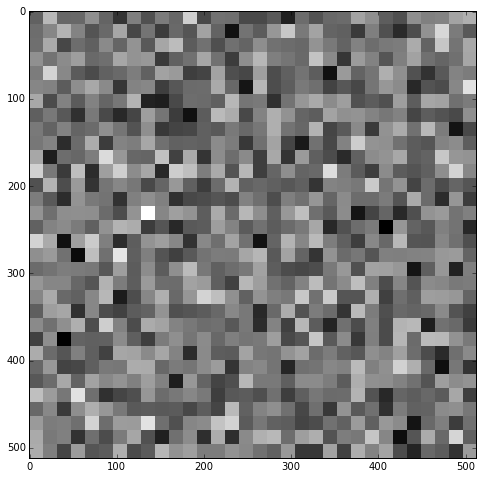

In [23]:
imshow(test)

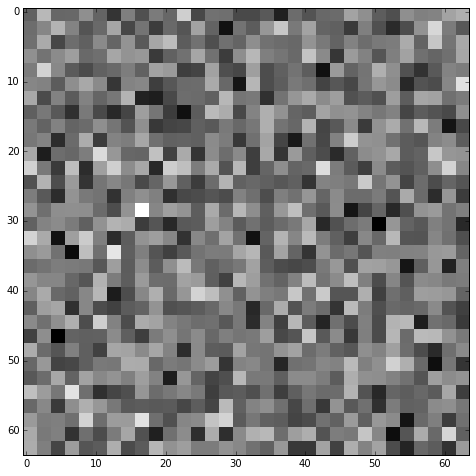

In [24]:
imshow(test[::8,::8])

In [25]:
test[::8,::8].shape

(64, 64)

In [83]:
maxNumExamples = 4500
subsampleFactor = 8

framesPerExample = 20
numExamples = min(len(allfiles) - framesPerExample + 3, maxNumExamples)
test = misc.imread(stimulus_dir + '/' + filename_prefix + str(1) + filename_suffix, flatten=True)
test = test[::subsampleFactor,::subsampleFactor]
examples = np.zeros((numExamples, framesPerExample, test.shape[0], test.shape[1]), dtype=uint8)
for i in xrange(min(len(allfiles), maxNumExamples + framesPerExample + 1)):
    if i % 1000 == 0:
        print 'Done with %d out of %d examples.' %(i, numExamples)
    im = misc.imread(stimulus_dir + '/' + filename_prefix + str(i+1) + filename_suffix, flatten=True)
    examplesWithFrame = min(framesPerExample,i+1)
    pairs = [(ex+max(0,i-framesPerExample+1),examplesWithFrame-1-ex) for ex in xrange(examplesWithFrame) if ex+max(0,i-framesPerExample+1) < numExamples]
    for p in pairs:
        examples[p[0],p[1],:,:] = im[::8,::8]
    

Done with 0 out of 3983 examples.
Done with 1000 out of 3983 examples.
Done with 2000 out of 3983 examples.
Done with 3000 out of 3983 examples.


In [84]:
examples.shape

(3983, 20, 64, 64)

# Get timing information

In [29]:
timing_dir = '/Users/lmcintosh/Git/deepRGC/datasets/experiment_2013_02_27/labels'
stim = scipy.io.loadmat(timing_dir + '/' + '20130227T112709.mat')
stim_vars = stim['ex']
stim_vals = stim_vars[0,0]

In [30]:
numFrames = stim_vals['ds']['vbl'][0][0].shape[0]
startStim = stim_vals['ds']['vbl'][0][0][0,0];
startData = 0;
normalizedTime = stim_vals['ds']['vbl'][0][0] - startStim;     # frames x conditions
exptLength = max(normalizedTime.flat)/60;   # in minutes
trialLength = size(normalizedTime,0);       # in frames
frameLength = (stim_vals['ds']['vbl'][0][0][trialLength-1,0] - stim_vals['ds']['vbl'][0][0][0,0])/(trialLength-1)
#stim_vals['ds']['vbl'][0][0][1,0] - stim_vals['ds']['vbl'][0][0][0,0];  # in seconds
trialDur = trialLength*frameLength;         # in seconds
numTrials = int(round(exptLength*60/trialDur))
numTrialsPerCondition = 10

stimType = [stim_vals['pa']['stimType'][0][0][i][0][0] for i in xrange(numTrials)]

In [31]:
normalizedTime.shape

(4000, 40)

In [32]:
def raster(event_times_list, color='k'):
    """
    Creates a raster plot
 
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
 
    Returns
    -------
    ax : an axis containing the raster plot
    """
    ax = gca()
    for ith, trial in enumerate(event_times_list):
        vlines(trial, ith + .5, ith + 1.5, color=color,linewidth=1.3)
    ylim(.5, len(event_times_list) + .5)
    
    return ax

In [33]:
n = 0
allTrials = []
for trial in xrange(normalizedTime.shape[1]):
    start = normalizedTime[0,trial]
    end   = normalizedTime[-1,trial]
    allTrials.append([s-start for s in cells[n] if end >= s and start <= s])
    


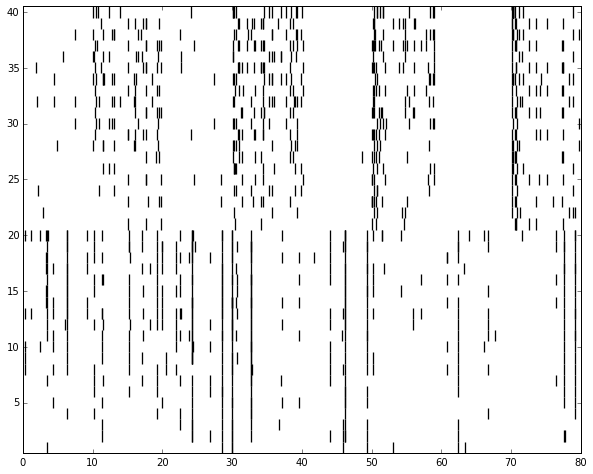

In [34]:
raster(allTrials)

In [35]:
binsPerTrial = int(ceil(trialDur*50))

# Smooth raw spike trains with 10ms std Gaussian to get PSTHs

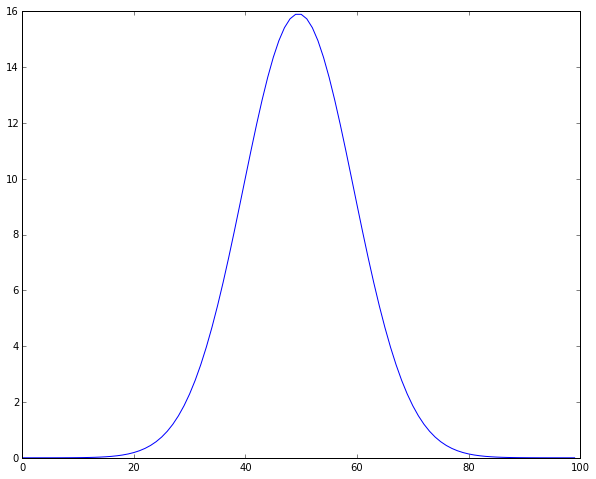

In [36]:
filt = gaussian(x=np.linspace(-.50,.50,100), sigma=.1, mu=0)
plot(filt)

In [37]:
labels_aligned = np.zeros((numCells, binsPerTrial, normalizedTime.shape[1]))
for n in xrange(numCells):
    for trial in xrange(normalizedTime.shape[1]):
        labels_aligned[n,:,trial] = labels[n, trial*binsPerTrial:(trial+1)*binsPerTrial]

numSpatialWhiteTrials = 20
spatialWhitePSTH = {}
for n in xrange(numCells):
    spatialWhitePSTH[n] = np.sum(labels_aligned[n,:,:numSpatialWhiteTrials], axis=1)/numSpatialWhiteTrials
    trueMean = np.mean(spatialWhitePSTH[n])
    spatialWhitePSTH[n] = np.convolve(filt, spatialWhitePSTH[n],'same')
    spatialWhitePSTH[n] *= trueMean / np.mean(spatialWhitePSTH[n])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


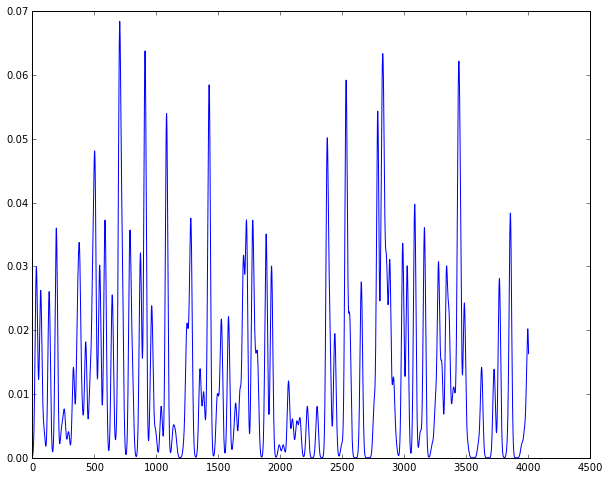

In [38]:
plot(spatialWhitePSTH[3])

In [43]:
correlations = {}
for n in xrange(numCells):
    correlations[n] = np.nanmean([pearsonr(spatialWhitePSTH[n], np.convolve(filt,labels_aligned[n,:,t],mode='same'))[0] for t in xrange(numSpatialWhiteTrials)])

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/scipy/stats/stats.py:2436: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:607: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [44]:
allCorrs = array(correlations.values())

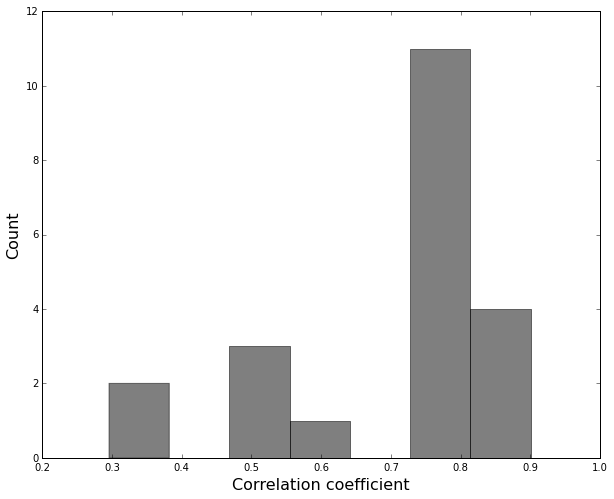

In [45]:
hist(allCorrs[~isnan(allCorrs)], 7, facecolor='k', alpha=0.5)
xlabel('Correlation coefficient', fontsize=16)
ylabel('Count', fontsize=16)

## Which neuron is the most precise?

In [46]:
best_neuron = np.nanargmax(allCorrs)

In [47]:
correlations[best_neuron]

0.90036172279360316

In [48]:
spatialWhitePSTH[best_neuron].shape

(4003,)

# Troubleshoot stimulus  
Why is the network just learning the average firing rate?

### STA

In [85]:
# for now choose a neuron
n = best_neuron

In [86]:
# Since I'm now using PSTHs, we have to restrict the number of examples to a single trial
X = examples[:spatialWhitePSTH[best_neuron].shape[0]-framesPerExample]
numExamples = X.shape[0]

# Zero-mean the data
mean_img = np.mean(X, axis=0)
X -= mean_img

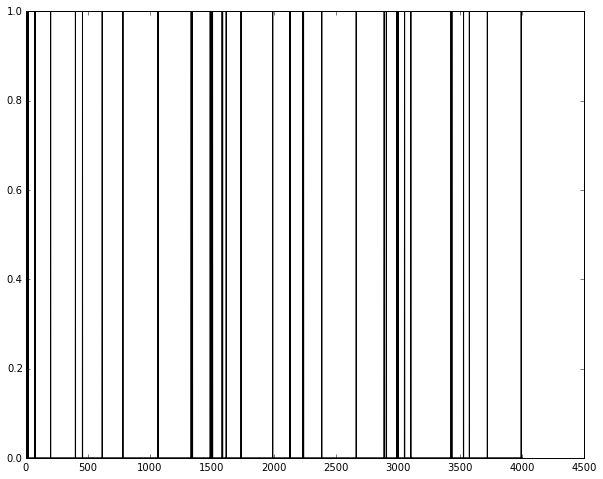

In [87]:
plot(labels_aligned[n, :, 0], 'k')

In [88]:
X.shape

(3983, 20, 64, 64)

In [96]:
labels_aligned[n, framesPerExample: , 0].shape

(3983,)

In [93]:
def sta(stimulus, spiketrain, numFrames=20):
    numSpikes = np.sum(spiketrain)
    sta = np.dot(stimulus.T, spiketrain)
    sta /= numSpikes
    return sta.T    

In [97]:
mySTA = sta(X, labels_aligned[n, framesPerExample:, 0])

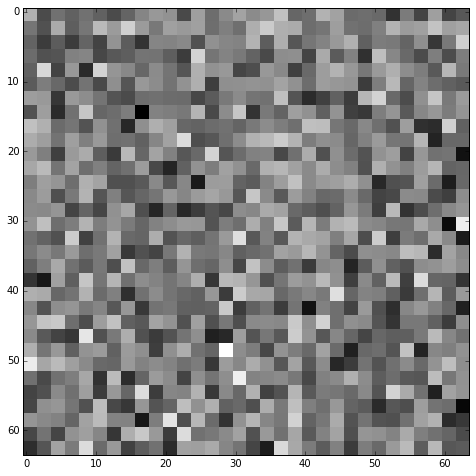

In [117]:
imshow(mySTA[10])

# Nothing really there. Let's simulate data using an LN model

# Train a network!

In [239]:
from utils.classifiers.convnet import init_five_layer_convnet
from utils.classifiers.convnet import five_layer_convnet

In [240]:
model = init_five_layer_convnet(input_shape=(20,64,64), num_classes=1, filter_sizes=(5,5,5), 
                                  num_filters=(32,32,64,128))

In [293]:
# Since I'm now using PSTHs, we have to restrict the number of examples to a single trial
X = examples[:spatialWhitePSTH[best_neuron].shape[0]-framesPerExample]
numExamples = X.shape[0]

# Divide examples into training, validation, and test sets
trainMask = np.random.choice(X.shape[0], size=X.shape[0]/2, replace=False)
valMask   = np.random.choice(X.shape[0], size=X.shape[0]/4, replace=False)
testMask  = np.random.choice(X.shape[0], size=X.shape[0]/4, replace=False)

X_train = X[trainMask]
X_val   = X[valMask]
X_test  = X[testMask]

# Zero-mean the data
mean_img = np.mean(X_train, axis=0)
X_train -= mean_img
X_val -= mean_img
X_test -= mean_img

In [295]:
# for now choose a neuron
n = best_neuron

# move labels into same space as X
# the following works only when label precision is same as X
#y = labels[n, framesPerExample:(numExamples+framesPerExample)].astype(int)
y = spatialWhitePSTH[best_neuron] / np.max(spatialWhitePSTH[best_neuron])
y = y[framesPerExample:(numExamples+framesPerExample)]

y_train = y[trainMask]
y_val   = y[valMask]
y_test  = y[testMask]

In [298]:
y_train.shape

(1991,)

In [299]:
y_val.shape

(995,)

In [316]:
X_val.shape

(995, 20, 64, 64)

In [321]:
from utils.classifier_trainer import ClassifierTrainer

trainer = ClassifierTrainer()
learning_rate = 1e-2
reg = 1e-3
dropout = 1.0
num_epochs = 3

# choose best learning rate from cross validation with 1 epoch
#lr_hist = {} # for lr in logspace(-6,-2,10):
#lr = lr_hist.keys()[np.argmax(lr_hist.values())] # lr of 0.00016681005372000591 for 0.2425 val acc

# choose best regularization from cross validation with 1 epoch
#r_hist = {} # for r in logspace(-5,-1,10)
#r = r_hist.keys()[np.argmax(r_hist.values())] # r of 0.00016681005372000591 for 0.2425 val acc


best_model = None
best_val_acc = 0

#for r in logspace(-5,-1,10):
finetuned_model, loss_history, train_acc_history, val_acc_history = trainer.train(X_train, y_train, X_val, y_val,
                                model, five_layer_convnet,
                                learning_rate=learning_rate, reg=reg, update='rmsprop',
                                dropout=dropout, num_epochs=num_epochs, verbose=True)
#print 'Validation accuracy %s for learning rate %s.' %(np.max(val_acc_history), lr)
print 'Validation accuracy %s for regularization %s.' %(np.max(val_acc_history), reg)

if np.max(val_acc_history) > best_val_acc:
    best_model = finetuned_model
    best_val_acc = np.max(val_acc_history)

#lr_hist[lr] = np.max(val_acc_history)
#r_hist[r] = np.max(val_acc_history)

starting iteration  0
Finished epoch 0 / 3: cost 0.057058, train: 0.033033, val 0.030865, lr 1.000000e-02
starting iteration  10
Finished epoch 1 / 3: cost 0.037031, train: 0.033463, val 0.033043, lr 9.500000e-03
starting iteration  20
starting iteration  30
Finished epoch 2 / 3: cost 0.040042, train: 0.036952, val 0.031996, lr 9.025000e-03
starting iteration  40
starting iteration  50
Finished epoch 3 / 3: cost 0.039362, train: 0.036350, val 0.032680, lr 8.573750e-03
finished optimization. best validation accuracy: 0.033043
Validation accuracy 0.0330427208977 for regularization 0.001.


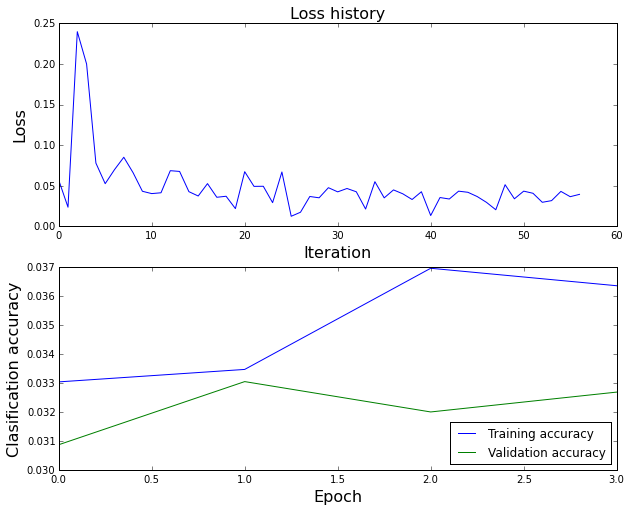

In [323]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)

ax2 = plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Clasification accuracy', fontsize=16)

# Grad check new mse_loss function

In [221]:
from utils.layers import mse_loss

In [222]:
example_x = randn(750)
example_y = randn(750)

In [223]:
loss, grad = mse_loss(example_x, example_y)
print 'Loss is %f, and grad has length %d.' %(loss, grad.shape[0])

Loss is 1.351746, and grad has length 750.


In [224]:
# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from utils.gradient_check import grad_check_sparse
f = lambda w: mse_loss(w, example_y)[0]
grad_numerical = grad_check_sparse(f, example_x, grad, 10)

numerical: 0.000251 analytic: 0.000251, relative error: 1.973219e-08
numerical: 0.000817 analytic: 0.000817, relative error: 2.174534e-09
numerical: 0.000539 analytic: 0.000539, relative error: 2.037923e-09
numerical: -0.000131 analytic: -0.000131, relative error: 2.292249e-08
numerical: 0.000706 analytic: 0.000706, relative error: 2.747741e-09
numerical: 0.000430 analytic: 0.000430, relative error: 1.320781e-09
numerical: 0.001214 analytic: 0.001214, relative error: 3.024810e-10
numerical: -0.000448 analytic: -0.000448, relative error: 6.880231e-09
numerical: 0.000899 analytic: 0.000899, relative error: 1.114192e-09
numerical: -0.000493 analytic: -0.000493, relative error: 6.793743e-09


#### Checks out!

# What does the prediction look like?

In [324]:
probs = five_layer_convnet(X_val, finetuned_model, return_probs=True)

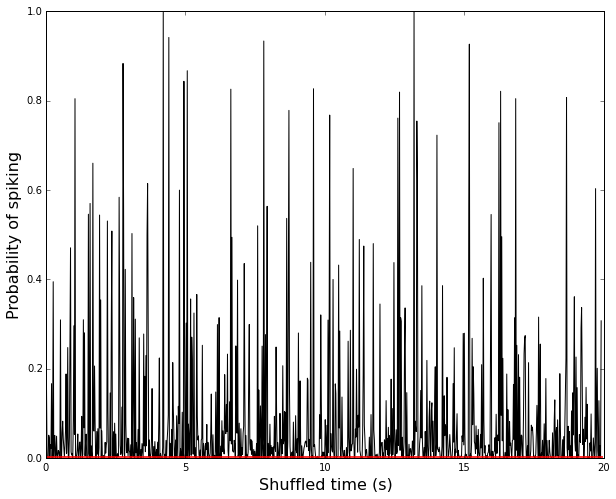

In [338]:
plot(np.linspace(0,len(y_val)*precision,len(y_val)), y_val, 'k', linewidth=1)
plot(np.linspace(0,len(y_val)*precision,len(y_val)), probs, 'r', linewidth=4, alpha=.8)
ylabel('Probability of spiking', fontsize=16)
xlabel('Shuffled time (s)', fontsize=16)